In [1]:
# Render our plots inline
%matplotlib inline

from requests import get
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

from pandas.io.json import json_normalize

from mycbr_py_api import MyCBRRestApi as mycbr

# Basic Settings
Here you need to specify where the API is running. The default port is 8080, so if you only change the machine, specify it's name in "server"

In [3]:
server = 'localhost'
#server = 'hv-6066.idi.ntnu.no'

port = '8080'
base_url = 'http://' + server + ':' + port + '/'

obj = mycbr(base_url)

# Case Representation

These methods show how to fetch an existing case representation from the APO 
Get the model contents: concept, attribute, attribute types

In [4]:
def get_globalsim(concept):
    raw = pd.DataFrame(requests.get(base_url + 'concepts/' + concept + '/amalgamationFunctions').json()) 
    global_sim = pd.DataFrame.from_records(raw).values.tolist()
    return global_sim

def get_attribute_value_range(concept, attribute):
    raw = requests.get(base_url + 'concepts/' + concept + '/attributes/' + attribute).json()
    value_range = json_normalize(raw).range
    return value_range

# Case Base
Get the model contents: concept, casebase, attribute, attribute types

In [5]:
def get_casebases():
    raw = pd.DataFrame(requests.get(base_url + 'casebase/').json()) 
    casebases = pd.DataFrame.from_records(raw).values.tolist()
    return casebases

def get_instances(concept, casebase):
    raw = pd.DataFrame(requests.get(base_url + 'concepts/' + concept + '/casebases/' + casebase + '/cases').json()) 
    instances = raw.apply(pd.to_numeric, errors='coerce').fillna(raw)
    return instances

# Convenience Functions
- Create plots for case base content

In [6]:
def plot_numeric(data, attribute):
    ax = sns.distplot(data[attribute].astype(int), rug=True, hist=True, kde=False)
    ax.set(xlabel=attribute, ylabel='Count', title=attribute + ' (mean: '+data[attribute].astype(int).mean().__str__()+')')

def plot_symbolic(data, attribute):
    ax = sns.countplot(x=attribute, data=data, order = data[attribute].value_counts().index)
    ax.set(xlabel=attribute, ylabel='Dist', title=attribute)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

# Examples

The following cells will show how the fetch the content and configuration of the CBR via the Rest API.


In [7]:
obj.getAllConcepts()

['car']

In [8]:
obj.getAllAttributes()

{'zip': 'IntegerDesc',
 'door': 'IntegerDesc',
 'code': 'IntegerDesc',
 'color': 'SymbolDesc',
 'year': 'IntegerDesc',
 'mile': 'IntegerDesc',
 'ccm': 'IntegerDesc',
 'body': 'SymbolDesc',
 'speed': 'IntegerDesc',
 'manufacturer': 'SymbolDesc',
 'price': 'FloatDesc',
 'fule': 'SymbolDesc',
 'model': 'SymbolDesc',
 'power': 'IntegerDesc',
 'id': 'IntegerDesc'}

In [9]:
obj.getAllAmalgamationFunctions()

['weighted_gsf', 'equal_weight_gsf']

In [10]:
get_attribute_value_range('car', 'fule')  # returns the value range for an attribute (min/max for numbers; entire list for symbols)

0    [diesel, gasoline]
Name: range, dtype: object

In [11]:
obj.getCaseBaseIDs() # returns the list of existing case bases

['main_casebase']

In [12]:
get_instances('car','main_casebase').head() # returns the contents of the case base

,body,caseID,ccm,code,color,door,fule,id,manufacturer,mile,model,power,price,similarity,speed,year,zip
0,station_wagon,car175,1800,685,light_gray;,5,gasoline,176,audi,15903,a4_1.8,125,38499,1,183,1996,3
1,sedan,car174,2400,562,orange;,4,gasoline,175,audi,34869,a6_2.4,165,43399,1,213,1996,2
2,fastback,car173,1800,437,turquoise;,2,gasoline,174,vw,101704,golf,60,10699,1,183,1995,6
3,station_wagon,car172,2800,187,white;,5,gasoline,173,bmw,60484,328i,193,34999,1,213,1995,5
4,fastback,car179,1600,695,yellow;,2,gasoline,180,bmw,9975,316i,102,36799,1,183,1997,1


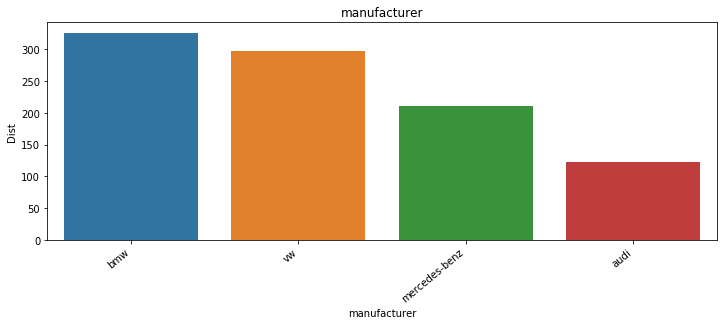

In [13]:
plt.rcParams["figure.figsize"] = (12, 4)
plot_symbolic(get_instances('car','main_casebase'), 'manufacturer')

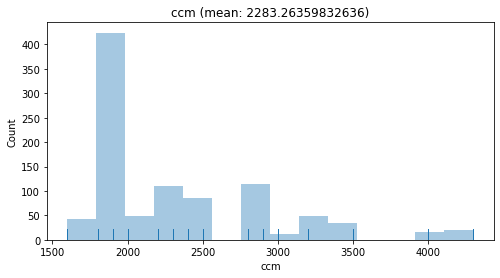

In [14]:
plt.rcParams["figure.figsize"] = (8, 4)
plot_numeric(get_instances('car','main_casebase'), 'ccm')

# Retrieval functions & visualizations
Example retrieval function that serve different purposes
- retrieve_k_sim_byID: This function uses the retrievalByID endpoint where a queryID is given (together with concept name, casebase name and k number of cases to be returned)

In [85]:
def retrieve_k_sim_byID(concept, casebase, amalgamationFct, queryID, k):
    raw = requests.get(base_url + 'concepts/' + concept + '/casebases/' + casebase + '/amalgamationFunctions/' + amalgamationFct +'/retrievalByCaseID?caseID=' + queryID + '&k=' + k ).json()
    results = pd.DataFrame.from_dict(raw.items())
    results.columns = ['caseID', 'similarity']
    results = results.apply(pd.to_numeric, errors='coerce').fillna(results).sort_values(by='similarity', ascending=False)
    return results

def plot_retrieve_k_sim_byID(data):
    plt.xticks(rotation=35)
    ax = sns.barplot(x='caseID', y="similarity", data=data)
    
def retrieve_k_sim_byID_content(concept, casebase, amalFct, queryID, k):
    raw = pd.DataFrame(requests.get(base_url + 'concepts/' + concept + '/casebases/' + casebase + '/amalgamationFunctions/' + amalFct + '/retrievalByCaseIDWithContent?caseID=' + queryID + '&k=' + k).json()) 
    results = raw.apply(pd.to_numeric, errors='coerce').fillna(raw).sort_values(by='similarity', ascending=False)
    results['similarity'] = results['similarity'].astype(float)
    returned_df = results.apply(pd.to_numeric, errors='coerce').fillna(results)
    return results

def plot_retrieved_scatter(data, x_attr):
    plt.xticks(rotation=35)
    ax = sns.scatterplot(x=x_attr, y='similarity', data=data)



# Retrieval Examples

In [78]:
# Find most similar cases 
result_caseIDs = retrieve_k_sim_byID('car', 'main_casebase', 'weighted_gsf', 'car175', '60')
result_caseIDs.head(10)

,caseID,similarity
0,car175,1
1,car771,0.937041
2,car188,0.936184
3,car659,0.933267
4,car446,0.930947
5,car836,0.924294
6,car566,0.909969
7,car568,0.904245
8,car620,0.902016
9,car120,0.900088


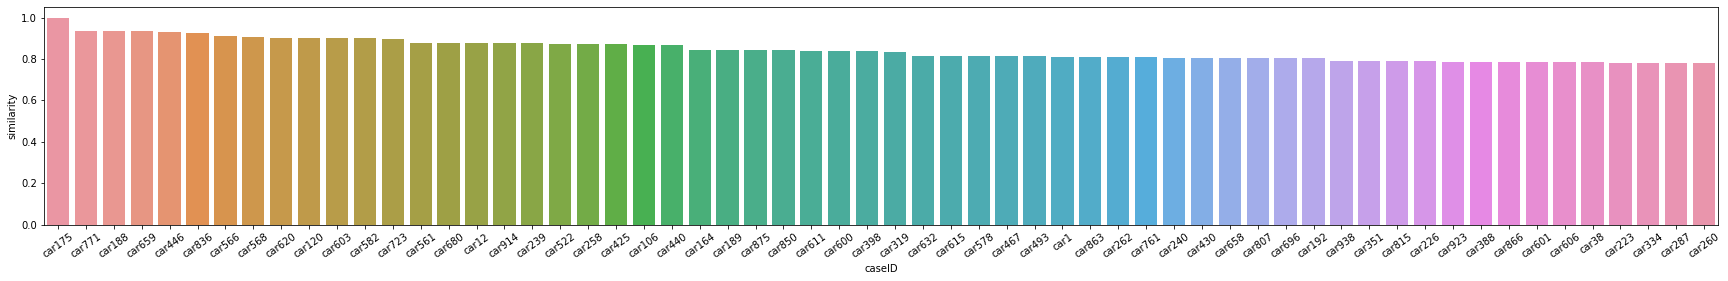

In [79]:
# Plot most similar cases - this requires result_caseIDs from the previous cell (called retrieve_k_sim_byID(..))
plt.rcParams["figure.figsize"] = (30, 4)
plot_retrieve_k_sim_byID(result_caseIDs)

In [86]:
# Find most similar cases and get the full case content for them
result_fullCases = retrieve_k_sim_byID_content('car', 'main_casebase', 'weighted_gsf', 'car175', '70')
result_fullCases.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70 entries, 0 to 69
Data columns (total 17 columns):
body            70 non-null object
caseID          70 non-null object
ccm             70 non-null int64
code            70 non-null int64
color           70 non-null object
door            70 non-null int64
fule            70 non-null object
id              70 non-null int64
manufacturer    70 non-null object
mile            70 non-null int64
model           70 non-null object
power           70 non-null int64
price           70 non-null int64
similarity      70 non-null float64
speed           70 non-null int64
year            70 non-null int64
zip             70 non-null int64
dtypes: float64(1), int64(10), object(6)
memory usage: 9.8+ KB


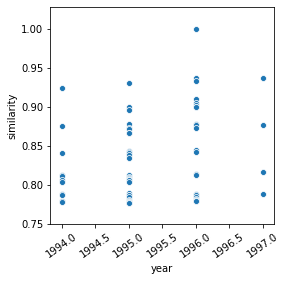

In [88]:
def plot_retrieved_scatter(data, x_attr):
    plt.xticks(rotation=35)
    ax = sns.scatterplot(x=x_attr, y='similarity', data=data)
    
# Create a scatter plot showing the similarity vs. a specified attribute
plt.rcParams["figure.figsize"] = (4, 4)
plot_retrieved_scatter(result_fullCases, 'year')

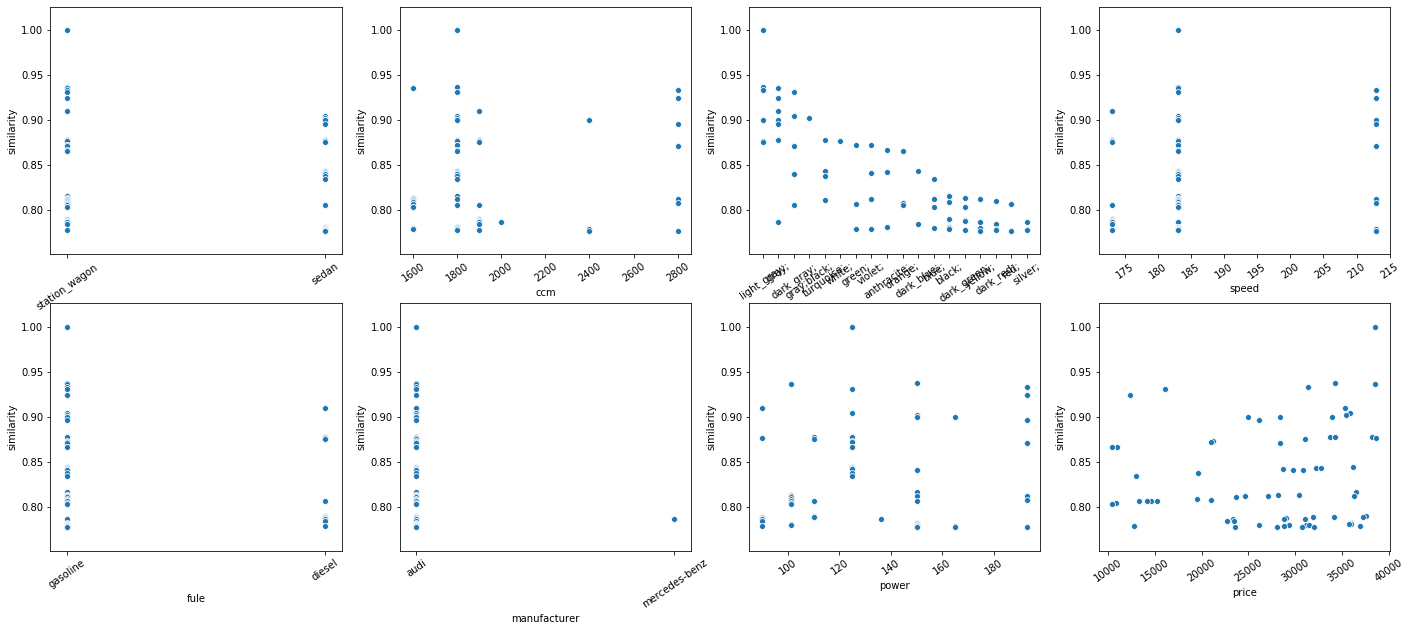

In [90]:
fig = plt.figure(figsize=(24,10))

plt.subplot(2, 4, 1)
plot_retrieved_scatter(result_fullCases, 'body')

plt.subplot(2, 4, 2)
plot_retrieved_scatter(result_fullCases, 'ccm')

plt.subplot(2, 4, 3)
plot_retrieved_scatter(result_fullCases, 'color')

plt.subplot(2, 4, 4)
plot_retrieved_scatter(result_fullCases, 'speed')

plt.subplot(2, 4, 5)
plot_retrieved_scatter(result_fullCases, 'fule')

plt.subplot(2, 4, 6)
plot_retrieved_scatter(result_fullCases, 'manufacturer')

plt.subplot(2, 4, 7)
plot_retrieved_scatter(result_fullCases, 'power')

plt.subplot(2, 4, 8)
plot_retrieved_scatter(result_fullCases, 'price')

plt.show()